In [1]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts 

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import vector_tools as vt

### Data retrieved and collected 
The study consisted of deploying a mooring within the Stillwater Kelp forest from July 22nd to September 8th:
- Central mooring was dropped at a location with approximately 10 meters of continuous kelp coverage in all directions (N36.56196, W121.94176)
- Maximum water depth was 38ft (11.6m), with an average of 34ft (10.4m)
- HOBO temperature logger pro V2's attached to a taut line suspended by subsurface buoy at the mooring weight
    - Loggers placed along the line at 9.7, 9.4, 9.1, 8, 6, 4, and 2 meters below the surface
    - Each logger sampled continuously at 1 minute intervals
- Teledyne RDI ADCP platform placed within relatively clear sand patch within the forest (N36.56194210195769, W121.94175918358738), (36.56194989498659, -121.9417662787946)
    - First deployment (7/21/2022 - 8/14/2022)
        - Sampled continuously, 1-minute long ensembles averaging 70 pings/second
        - Bins start at 1m off bottom with .25m spacing between them
    - Second deployment (8/23/2022 - 8/30/2022)
        - Sampled in 20 minute bursts 1Hz (12 subpings/second)
- Nortek Vector ADV placed in tripod on the seafloor near kelp clusters, velocity transducers were 1m off the floor (36.56195999999164, -121.94174126537672)
    - Sampled in 20 minute bursts at 32Hz
- Monterey Bay Aquarium Research Institute M1 Mooring data (7/21/2022 - 9/9/2022)
- NOAA National Buoy Data Center Statino 46042 (July - September)
- Radial kelp surveys conducted via SCUBA 
    - Each survey consisted of 8 4mx10m transects run at 0, 45, 90, 135, 180, 225, 270, 315 degree headings
    - Each individual "stipe bundle" within the 4m diameter had its distance, heading on the transect, and diameter recorded
    - A "stipe bundle" is subjectively defined as a any tightly spaced cluster of stipes, which sometimes includes multiple kelp individuals have grown so close together that they are indistinguishable from a single shape
- Turbulent Kintetic Energy Dissipation Rate ($\epsilon$)
    - Any velocity measurements with a Signal-to-noise ratio below 10 or a Correlation below 60% on any of the three beams is removed
    - ADV data is despiked using an exanding ellipsoid algorithm outlined in Wheeler and Giddings (2023)
    - The data gaps created by the quality control and despiking process are then linearly interpolated over gaps <= 1 second, with larger gaps being filled in with the average of the orginal values present within the gap
    - These "fixed" data points are labelled as "unoriginal", and a ratio of unoriginal to original data points is recorded for future quality control
    - $\epsilon$ is estimated from the vertical velocity spectra of 20-minute ADV bursts with an unoriginal ratio < 0.25
    - Each burst was filtered using a Hann window with 60-second segments and 50% overlap resulting in 106 degrees of freedom (Thomson and Emery, 2014)
    - Locating the inertial subrange (ISR):
        - Initial boundaries of the ISR were estimated as the peak surface wave frequency (low boundary) and the instrument noise floor (high boundary), which was consistently set at 3.5 Hz
        - To estimate the peak wave frequency, pressure spectra recorded by the ADV was converted to vertical velocity via linear wave theory
        - Within these boundaries, every sequence of points with a minimum range of 1Hz was fit with a power-law curve and a power-law with fixed -5/3 slope, both using least squares error
    - Calculating $\epsilon$:
        - $\epsilon(\omega)$ = ${\langle\frac{S_{ww}(\omega) \omega^\frac{5}{3}}{\alpha J_{33}(\omega)}\rangle} ^\frac{3}{2}$
        - $S_{ww}(\omega)$ = Vertical velocity spectra at omega
        - $\omega$ = radian frequency being evaluated
        - $\alpha$ = 1.5 (Kolmogoroff's constant)
        - $J_{33}(\omega)$ = integral over 3D wavenumber space that depends on the mean flow and wave-orbital velocities
        - $\epsilon$ is estimated over all radian frequencies within proposed inertial subrange
    - The $\epsilon$ estimates were then run through a series of quality control tests:
        - The intercept of the fit is > standard error in the intercept (Jones and Monosmith, 2008)
        - The average of the noise floor magnitude < half the magnitude of spectrum at lower ISR boundary (Gerbi et al. 2009)
        - The slope ($\mu$) and slope error($\mu_{err}$) of the fit fall within acceptable boundaries:
            - $\mu$ - 2$\mu_{err}$ - .06 < -5/3 < $\mu$ + 2$\mu_{err}$ + .06 (Feddersen, 2010)
            - $\frac{|\mu + \frac{5}{3}|}{\mu_{err}}$ < 1.960 (Wheeler and Giddings, 2023)
        - Linear regression of $\epsilon(\omega)$ over suggested ISR has a slope that is statiscally indistinguishable from 0
    - From the suggested ISR ranges that pass all tests, the the fit with the lowest root mean square error from the -5/3 fit was chosen as the best
    - From this best fit, the mean of $\epsilon$ over the ISR is calculated and used as the final value of $\epsilon$ for the data burst

In [2]:
# ADCP data
adcp1 = xr.open_dataset('ADCP/adcp1.nc')
adcp1_5m = xr.open_dataset('ADCP/adcp1_5m.nc')
adcp1_10m = xr.open_dataset('ADCP/adcp1_10m.nc')
adcp1_10mroll = xr.open_dataset('ADCP/adcp1_10mroll.nc')

adcp2 = xr.open_dataset('ADCP/adcp2.nc')
adcp2_1m = xr.open_dataset('ADCP/adcp2_1m.nc')
adcp2_5m = xr.open_dataset('ADCP/adcp2_5m.nc')
adcp2_10m = xr.open_dataset('ADCP/adcp2_10m.nc')
adcp2_1mroll = xr.open_dataset('ADCP/adcp2_1mroll.nc')
adcp2_10mroll = xr.open_dataset('ADCP/adcp2_10mroll.nc')

# ADV data
adv1 = xr.open_dataset('ADV/adv1IntAvg.nc')
adv2 = xr.open_dataset('ADV/adv2IntAvg.nc')

# Temperature data
temp = xr.open_dataset('Temperature/temp_w_rho.nc')

# M1 data
m1_ns = xr.open_dataset('M1/m1_ns.nc')
m1_ew = xr.open_dataset('M1/m1_ew.nc')
m1_temp = xr.open_dataset('M1/m1_temp.nc')
m1_wind = xr.open_dataset('M1/m1_wind.nc')

# NBDC 46042 data
nbdc_july = xr.open_dataset('46042_Buoy/nbdc_july.nc')
nbdc_aug = xr.open_dataset('46042_Buoy/nbdc_aug.nc')
nbdc_sept = xr.open_dataset('46042_Buoy/nbdc_sept.nc')

# Turbulent dissipation data
eps1 = xr.open_dataset('Dissipation/eps1Int_final.nc')
eps2 = xr.open_dataset('Dissipation/eps2Int_final.nc')

In [96]:
m1_wind.time.values

array(['2022-07-21T07:00:00.000000000', '2022-07-21T07:00:00.000000000',
       '2022-07-21T07:00:00.000000000', ...,
       '2022-09-09T06:31:00.000000000', '2022-09-09T06:41:00.000000000',
       '2022-09-09T06:51:00.000000000'], dtype='datetime64[ns]')

### Dataset can be divided into two deployments (d1 and d2)

In [3]:
# Deployment 1

# Slice datasets by most limiting timeframe
# Temperature
temp_dep1 = temp.sel(time=slice('2022-08-02T09:40:00.000000000', '2022-08-11T17:59:00.000000000'))

# ADCP
adcp_dep1 = adcp1.sel(time=slice('2022-08-02T09:40:00.000000000', '2022-08-11T17:59:00.000000000'))
adcp_10mroll_dep1 = adcp1_10mroll.sel(time=slice('2022-08-02T09:40:00.000000000', '2022-08-11T17:59:00.000000000')) # 10 min rolling window for better looking data

# ADV
adv_dep1 = adv1.sel(time=slice('2022-08-02T09:40:00.000000000', '2022-08-11T17:59:00.000000000'))
adv_1m_dep1 = adv1_1m.sel(time=slice('2022-08-02T09:40:00.000000000', '2022-08-11T17:59:00.000000000'))# Using 1min average since raw data is too chaotic
adv_5m_dep1 = adv1_5m.sel(time=slice('2022-08-02T09:40:00.000000000', '2022-08-11T17:59:00.000000000'))
adv_10m_dep1 = adv1_10m.sel(time=slice('2022-08-02T09:40:00.000000000', '2022-08-11T17:59:00.000000000'))


### Plot velocity components in relation to temperature time series for D1

Text(0.5, 1.0, 'Velocity direction (1m Above Seafloor)')

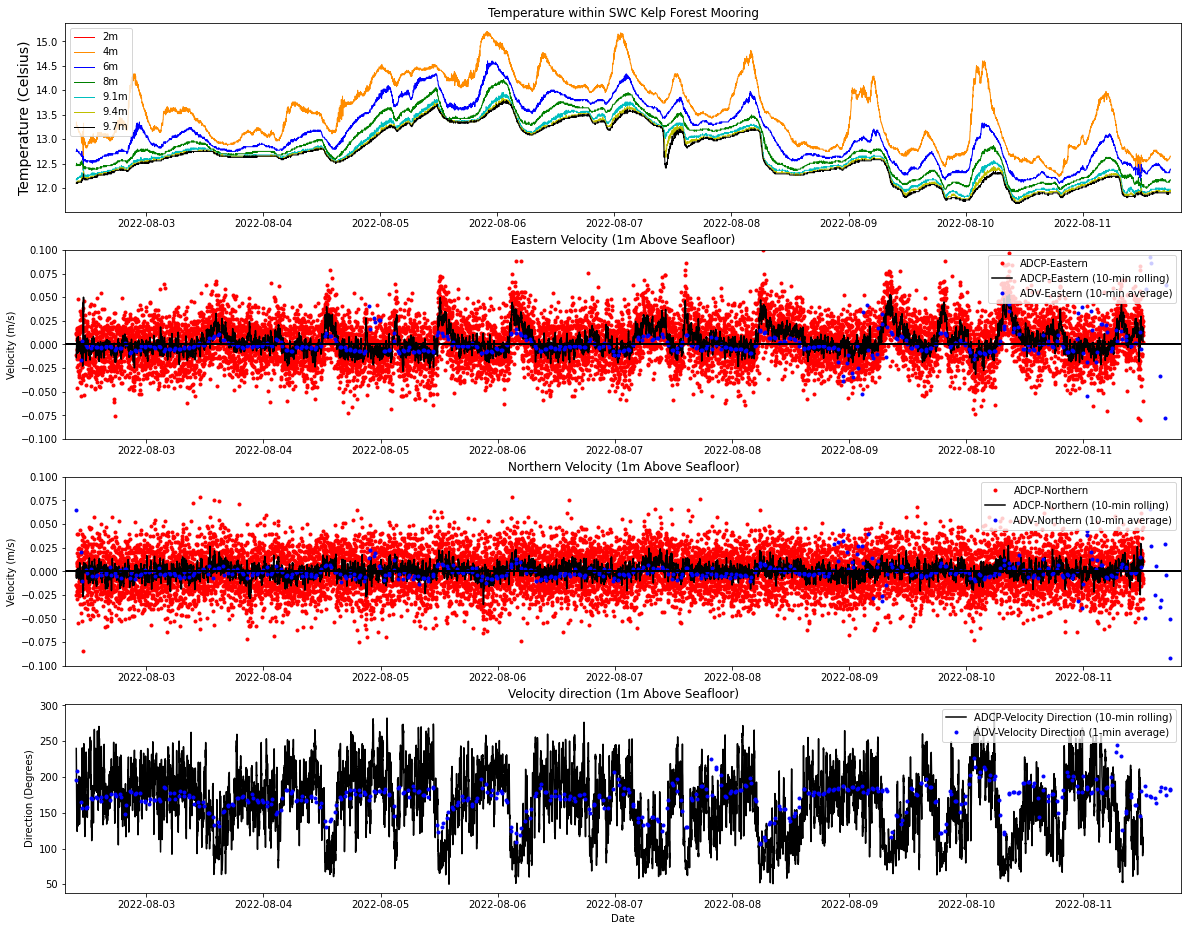

In [13]:
# TEMPERATURE
plt.figure(figsize = (20,16))

plt.subplot(411)
plt.plot(temp_dep1.time, temp_dep1.Temperature.isel(depth=0), 'r-', lw = 1)
plt.plot(temp_dep1.time, temp_dep1.Temperature.isel(depth=1), 'darkorange', lw = 1)
plt.plot(temp_dep1.time, temp_dep1.Temperature.isel(depth=2), 'b-', lw = 1)
plt.plot(temp_dep1.time, temp_dep1.Temperature.isel(depth=3), 'g-', lw = 1)
plt.plot(temp_dep1.time, temp_dep1.Temperature.isel(depth=4), 'c-', lw = 1)
plt.plot(temp_dep1.time, temp_dep1.Temperature.isel(depth=5), 'y-', lw = 1)
plt.plot(temp_dep1.time, temp_dep1.Temperature.isel(depth=6), 'k-', lw = 1)

plt.ylabel("Temperature (Celsius)", fontsize=14)
plt.margins(x=.01)
plt.title('Temperature within SWC Kelp Forest Mooring')
plt.legend(['2m','4m','6m','8m','9.1m', '9.4m', '9.7m'], loc = 'upper left')
#=================================================================================================
# Eastern Velocity
plt.subplot(412)
plt.plot(adcp_dep1.time, adcp_dep1.East.isel(BinDist=1), '.r', label = 'ADCP-Eastern')
plt.plot(adcp_10mroll_dep1.time, adcp_10mroll_dep1.East,'-k', label = 'ADCP-Eastern (10-min rolling)')
plt.plot(adv_10m_dep1.time, adv_10m_dep1.East, '.b', label = 'ADV-Eastern (10-min average)')
plt.ylim(-.1,.1)
plt.legend(loc = 'upper right')
plt.axhline(y=0, c='black', lw=2)
plt.margins(x=.01)
plt.ylabel('Velocity (m/s)')
plt.title('Eastern Velocity (1m Above Seafloor)')
#=================================================================================================
# Northern Velocity
plt.subplot(413)
plt.plot(adcp_dep1.time, adcp_dep1.North.isel(BinDist=1), '.r', label = 'ADCP-Northern')
plt.plot(adcp_10mroll_dep1.time, adcp_10mroll_dep1.North,'-k', label = 'ADCP-Northern (10-min rolling)')
plt.plot(adv_10m_dep1.time, adv_10m_dep1.North, '.b', label = 'ADV-Northern (10-min average)')
plt.ylim(-.1,.1)
plt.legend(loc = 'upper right')
plt.axhline(y=0, c='black', lw=2)
plt.margins(x=.01)
plt.ylabel('Velocity (m/s)')
plt.title('Northern Velocity (1m Above Seafloor)')
#=================================================================================================
# Velocity direction
plt.subplot(414)
plt.plot(adcp_10mroll_dep1.time, adcp_10mroll_dep1.Direction,'-k', label = 'ADCP-Velocity Direction (10-min rolling)')
plt.plot(adv_10m_dep1.time, adv_10m_dep1.CDIR, '.b', label = 'ADV-Velocity Direction (1-min average)')
plt.legend(loc = 'upper right')
plt.margins(x=.01)
plt.ylabel('Direction (Degrees)')
plt.xlabel('Date')
plt.title('Velocity direction (1m Above Seafloor)')

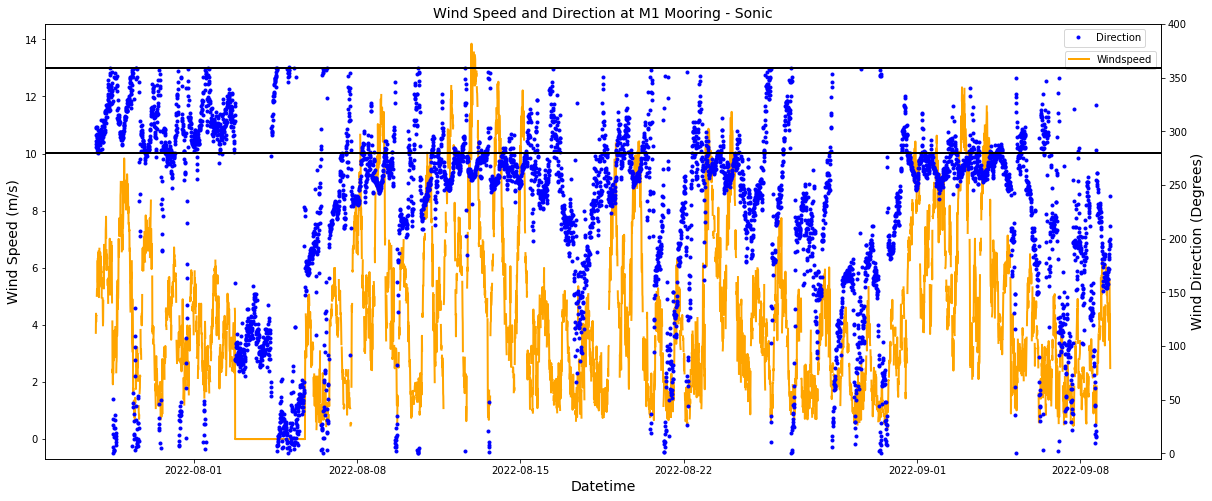

In [59]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (20, 8))

# make a plot

lns1 = ax.plot(m1_wind.time, m1_wind.wind_speed_sonic, 'orange', lw = 2, label='Windspeed')
# set x-axis label
ax.set_xlabel("Datetime", fontsize = 14)
# set y-axis label
ax.set_ylabel("Wind Speed (m/s)", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
lns2 = ax2.plot(m1_wind.time, m1_wind.wind_from_direction_sonic, '.b', lw = 2, label='Direction')
ax2.set_ylim(-5,400)
ax2.set_ylabel("Wind Direction (Degrees)",fontsize=14)


# Solution for having two legends
leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax.legend(loc=1, bbox_to_anchor=(1,.95)) #(leg, labs, loc=0)
plt.axhline(y=359, c='black', lw=2)
plt.axhline(y=280, c='black', lw=2)
plt.title('Wind Speed and Direction at M1 Mooring - Sonic', fontsize=14)
plt.legend(bbox_to_anchor=(.99,1))

plt.margins(x=.01, y = .5)
#plt.show()
#plt.savefig('Plots/m1_windspeed_+_direction.PNG')